# Going Deeper (CV)
# 3. 없다면 어떻게 될까? (ResNet Ablation Study) [프로젝트]

## 3-1. 프로젝트: ResNet Ablation Study

### 0) 라이브러리 버전 확인하기

In [ ]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.12.0
1.22.4


### 1) ResNet 기본 블록 구성하기

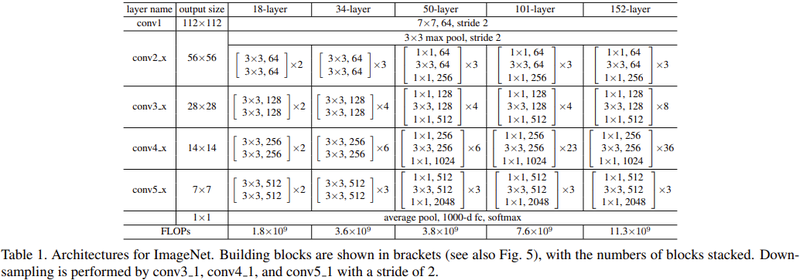

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

ResNet34
- shortcut = x
- 첫 블록의 첫 layer는 strides=1
- 첫 블록을 제외한 나머지 블록의 첫 layer는 strides=2
- channel이 바뀔 때마다 shortcut에도 conv2D연산
- 블록의 마지막엔 Activation 직전에 x와 shortcut을 더함  

ResNet50
- shortcut = x
- 첫 블록의 첫 layer는 strides=1
- 첫 블록을 제외한 나머지 블록의 첫 layer는 strides=2
- 첫 블록의 shortcut엔 conv2D연산
- 블록의 마지막엔 Activation 직전에 x와 shortcut을 더함


In [ ]:
def residual_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   strides_on=True,
                   is_50=False,
                   ):
    x = input_layer

    for cnn_num in range(num_cnn):
        shortcut = x
        if is_50 == True:
            strides = 1
            if cnn_num == 0:    # 블록의 첫 번째 conv인지 확인
                if strides_on == True:  # 블록의 첫 conv레이어의 stride 여부
                    strides = 2
                shortcut = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding="same",
                                        kernel_initializer="he_normal",
                                        strides=strides
                                        )(shortcut)
                shortcut = keras.layers.BatchNormalization()(shortcut)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(1, 1),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    strides=strides # 첫 번째 블록의 첫 번째 conv연산에 strides=2
                                    )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)

            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1, 1),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    )(x)
            x = keras.layers.BatchNormalization()(x)

        else:
            strides = 1
            if cnn_num == 0 and strides_on == True:    # 블록의 첫 conv레이어의 stride 여부
                strides = 2
                shortcut = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding="same",
                                        kernel_initializer="he_normal",
                                        strides=strides
                                        )(shortcut)
                shortcut = keras.layers.BatchNormalization()(shortcut)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    strides=strides # 첫 번째 블록의 첫 번째 conv연산에 strides=2
                                    )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    )(x)
            x = keras.layers.BatchNormalization()(x)

        x = keras.layers.add([x, shortcut])
        x = keras.layers.Activation("relu")(x)
    return x

## 2) ResNet-34, ResNet-50 Complete Model

In [ ]:
def build_resnet(input_shape=(32, 32, 3),
                 num_cnn_list=[3, 4, 6, 3],
                 channel_list=[64, 128, 256, 512],
                 num_classes=10,
                 is_50=False,
                 ):

    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer="he_normal",
                            padding="same",
                            )(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPool2D(2, 2)(x)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        if i == 0:
            strides_on = False
        else:
            strides_on = True
        x = residual_block(input_layer=x,
                           num_cnn=num_cnn,
                           channel=channel,
                           strides_on=strides_on,
                           is_50=is_50,
                           )

    x = keras.layers.AveragePooling2D(padding="same")(x)
    x = keras.layers.Flatten()(x)

    output = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(input_layer, output)

    return model

#### ResNet-34

In [ ]:
resnet34 = build_resnet()
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

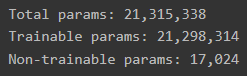  
예시와 같은 결과가 나오는 것을 확인할 수 있습니다.

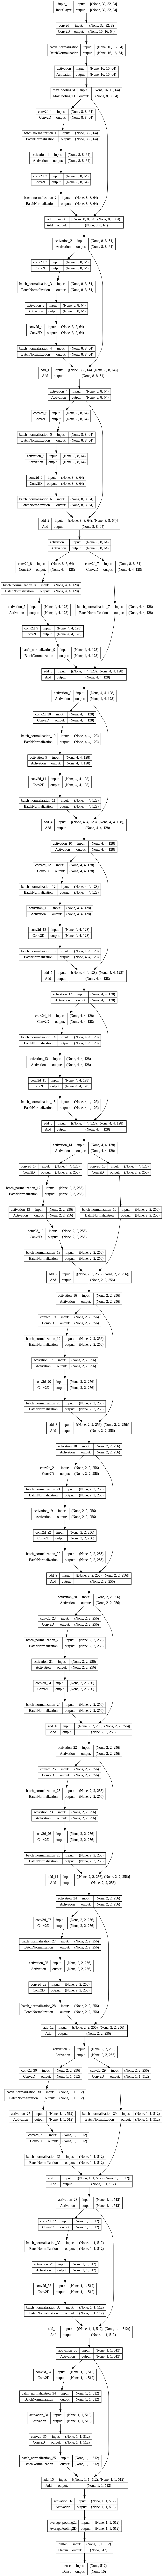

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(resnet34, to_file='resnet34.png', show_shapes=True)

residual 연산이 잘 수행되는 것을 그림으로 확인할 수 있습니다.

#### ResNet-50

In [ ]:
resnet50 = build_resnet(is_50=True)
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

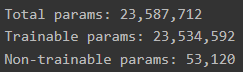  
예시에선 마지막 출력층을 제외한 모델의 파라미터만을 나타낸 것으로, 코드에서 출력층을 제외하고 summary()를 수행하면 같은 결과를 얻을 수 있습니다.

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(resnet50, to_file='resnet50.png', show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

## 3) 일반 네트워크(plain network) 만들기

In [ ]:
def residual_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   strides_on=True,
                   is_50=False,
                   is_plain=False,
                   ):
    x = input_layer

    for cnn_num in range(num_cnn):
        shortcut = x
        if is_50 == True:
            strides = 1
            if cnn_num == 0:
                if strides_on == True:
                    strides = 2
                if is_plain == False:   # plain 여부 조건문 추가
                    shortcut = keras.layers.Conv2D(filters=channel*4,
                                            kernel_size=(1, 1),
                                            padding="same",
                                            kernel_initializer="he_normal",
                                            strides=strides
                                            )(shortcut)
                    shortcut = keras.layers.BatchNormalization()(shortcut)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(1, 1),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    strides=strides
                                    )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)

            x = keras.layers.Conv2D(filters=channel*4,
                                    kernel_size=(1, 1),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    )(x)
            x = keras.layers.BatchNormalization()(x)

        else:
            strides = 1
            if cnn_num == 0 and strides_on == True:
                strides = 2
                if is_plain == False:
                    shortcut = keras.layers.Conv2D(filters=channel,
                                            kernel_size=(1, 1),
                                            padding="same",
                                            kernel_initializer="he_normal",
                                            strides=strides
                                            )(shortcut)
                    shortcut = keras.layers.BatchNormalization()(shortcut)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    strides=strides
                                    )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)

            x = keras.layers.Conv2D(filters=channel,
                                    kernel_size=(3, 3),
                                    padding="same",
                                    kernel_initializer="he_normal",
                                    )(x)
            x = keras.layers.BatchNormalization()(x)

        if is_plain == False:   # plain 여부 조건문 추가
            x = keras.layers.add([x, shortcut])
        x = keras.layers.Activation("relu")(x)
    return x

In [ ]:
def build_resnet(input_shape=(32, 32, 3),
                 num_cnn_list=[3, 4, 6, 3],
                 channel_list=[64, 128, 256, 512],
                 num_classes=10,
                 is_50=False,
                 is_plain=False,
                 ):

    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer="he_normal",
                            padding="same",
                            )(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPool2D(2, 2)(x)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        if i == 0:
            strides_on = False
        else:
            strides_on = True
        x = residual_block(input_layer=x,
                           num_cnn=num_cnn,
                           channel=channel,
                           strides_on=strides_on,
                           is_50=is_50,
                           is_plain=is_plain,
                           )

    x = keras.layers.AveragePooling2D(padding="same")(x)
    x = keras.layers.Flatten()(x)

    output = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(input_layer, output)

    return model

#### Plain-34

In [ ]:
plain34 = build_resnet(input_shape=(224, 224, 3), is_plain=True)
plain34.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_53 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_53 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_49 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_54 (Conv2D)          (None, 56, 56, 64)        3692

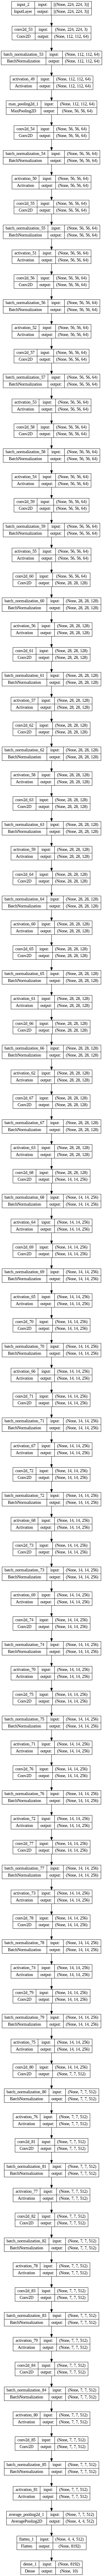

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(plain34, to_file='plain34.png', show_shapes=True)

In [ ]:
plain50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=True)
plain50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_86 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_86 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_87 (Conv2D)          (None, 56, 56, 64)        4160

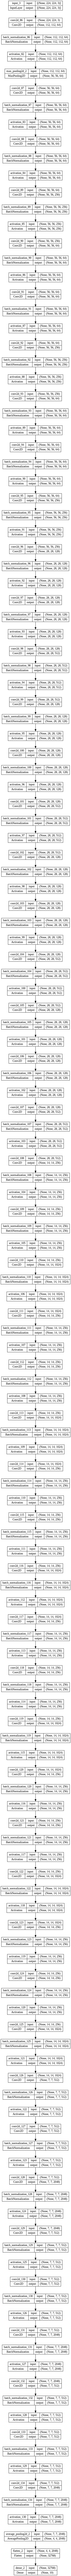

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(plain50, to_file='plain50.png', show_shapes=True)

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### Ablation Study

In [ ]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 (224, 224)로 변경
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
import tensorflow_datasets as tfds

BATCH_SIZE = 16     # 프로그램이 메모리 문제로 죽는 것을 방지하기 위해 배치 수를 낮춤
EPOCH = 10

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],    # 전체 데이터셋의 80퍼센트는 훈련에, 20퍼센트는 테스트에
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2C7X6O/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
resnet34 = build_resnet(input_shape=(224, 224, 3), num_classes=2)

resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 179s 122ms/step - loss: 0.8293 - accuracy: 0.5849 - val_loss: 0.8583 - val_accuracy: 0.5902
Epoch 2/10
1163/1163 [==============================] - 136s 117ms/step - loss: 0.7536 - accuracy: 0.6262 - val_loss: 0.7337 - val_accuracy: 0.6368
Epoch 3/10
1163/1163 [==============================] - 142s 122ms/step - loss: 0.7059 - accuracy: 0.6516 - val_loss: 0.6574 - val_accuracy: 0.6846
Epoch 4/10
1163/1163 [==============================] - 142s 122ms/step - loss: 0.6457 - accuracy: 0.6849 - val_loss: 0.9879 - val_accuracy: 0.6173
Epoch 5/10
1163/1163 [==============================] - 142s 122ms/step - loss: 0.5840 - accuracy: 0.7232 - val_loss: 0.5918 - val_accuracy: 0.7308
Epoch 6/10
1163/1163 [==============================] - 135s 116ms/step - loss: 0.4976 - accuracy: 0.7667 - val_loss: 0.6334 - val_accuracy: 0.7235
Epoch 7/10
1163/1163 [==============================] - 135s 116ms/step - loss: 0.4028 - accuracy: 0.8189 - val_

In [ ]:
plain34 = build_resnet(input_shape=(224, 224, 3), num_classes=2, is_plain=True)

plain34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain34 = plain34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 154s 119ms/step - loss: 0.7495 - accuracy: 0.5331 - val_loss: 0.7794 - val_accuracy: 0.5283
Epoch 2/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.7457 - accuracy: 0.5287 - val_loss: 1.0151 - val_accuracy: 0.5026
Epoch 3/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.7429 - accuracy: 0.5321 - val_loss: 0.7663 - val_accuracy: 0.5399
Epoch 4/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.7314 - accuracy: 0.5424 - val_loss: 0.7174 - val_accuracy: 0.5422
Epoch 5/10
1163/1163 [==============================] - 131s 112ms/step - loss: 0.7206 - accuracy: 0.5611 - val_loss: 0.9604 - val_accuracy: 0.5612
Epoch 6/10
1163/1163 [==============================] - 130s 112ms/step - loss: 0.6944 - accuracy: 0.6054 - val_loss: 1.0148 - val_accuracy: 0.6448
Epoch 7/10
1163/1163 [==============================] - 137s 118ms/step - loss: 0.6678 - accuracy: 0.6341 - val_

### 시각화

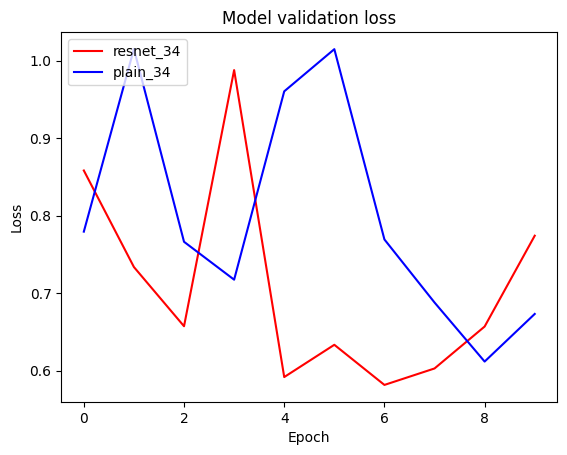

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_resnet34.history['val_loss'], 'r')
plt.plot(history_plain34.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

ResNet의 검증 손실이 평균적으로 Plain Network의 검증 손실보다 낮은 것을 확인할 수 있습니다.  
추가적으로 약 3회 정도의 훈련을 실시해도 비슷한 결과를 얻었습니다...만 사진이 한 장 빼고 날아가서 한 장만 첨부합니다.

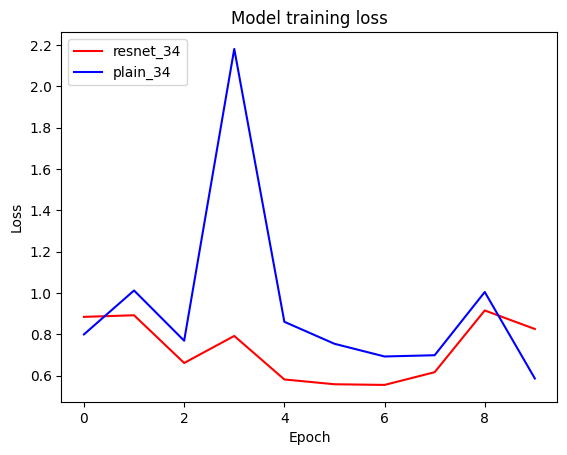

(이름을 바꾸지 않아서 그래프 이름은 training loss이지만 결과는 validation loss입니다.)  
재미있는 점은 위의 두 장의 사진 뿐만 아니라 몇 번의 추가 훈련의 결과에서도 에포크의 맨 처음과 끝부분은 Plain Network의 검증 손실이 더 낮게 나왔다는 점입니다.  
하지만 이유는 알 수 없었습니다..

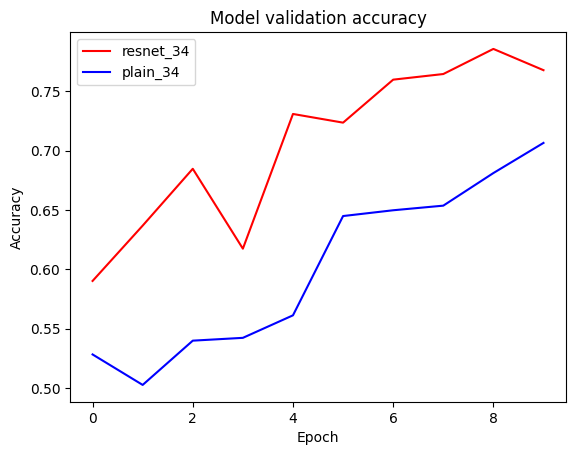

In [ ]:
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

검증 정확도도 ResNet이 더 높은 것을 알 수 있습니다.

## 결론

정리
- ResNet은 잔차 연결을 통해서 같은 깊이의 Plain Network보다 훈련이 잘 됩니다.
- 훈련이 더 잘 되었다고 판단한 이유는 ResNet이 PlainNet보다 검증손실은 적고 검증 정확도는 더 높았기 때문입니다.
  

추가적으로 알게된 점
- ResNet을 구성하는 데 있어서 잔차 연결을 하려면 잔차와 레이어를 통과한 값의 차원을 맞춰주는 테크닉이 추가적으로 필요했습니다.  
- strides가 차원을 맞춰주는 조건의 키워드 역할을 했습니다. strides를 2로 설정하여 레이어를 통과한 결과값의 차원을 절반으로 줄이는 것에 맞춰서 잔차 부분도 똑같이 차원을 맞춰주는 것이 코딩 파트의 핵심이었습니다.
- 모델을 훈련하는 데에 있어서 (224, 224, 3)크기의 이미지를 노드 학습때와 동일하게 배치 수를 256으로 설정하면 커널이 다운되는 문제가 있었습니다. 배치 수가 많을수록 epoch에서의 iteration은 줄어들어 훈련은 빠르지만 한 번에 메모리에 로드하는 이미지의 양이 많아 메모리 부족으로 커널이 다운되는 것 같습니다.
    - LMS 기준으로 배치 8에 이미지 10,000장 학습을 실행할 경우 학습을 다 끝내지 못하고 커널이 다운되었습니다. 배치 16에 이미지 1,000장은 학습에 성공했던 것으로 보아 배치 수와 이미지 데이터셋의 수를 이 사이의 수치로 적절히 조절하면 훈련에 성공할 것 같습니다.
    - 구글 코랩 기준으로 전체 이미지 23,262장을 로드하고 배치 수를 16으로 설정하면 학습에 성공하였습니다.